In [2]:
!pip install statannot


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
import pandas as pd
import copy
from scipy.special import softmax
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp as mc
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statannot import add_stat_annotation

In [18]:
def hairpin(grid_size: int):
    reward = [1,grid_size -2]
    blocks = []
    mid_a = int(grid_size // 5)
    mid_b = 2 * int(grid_size // 5)
    mid_c = 3 * int(grid_size // 5)
    mid_d = 4 * int(grid_size // 5)
    blocks_a = [[i, mid_a] for i in range(grid_size // 2 + 1 + grid_size // 4)]
    blocks_b = [[i, mid_b] for i in range(grid_size // 4 + 1, grid_size - 1)]
    blocks_c = [[i, mid_c] for i in range(grid_size // 2 + 1 + grid_size // 4)]
    blocks_d = [[i, mid_d] for i in range(grid_size // 4 + 1, grid_size - 1)]
    blocks = blocks_a + blocks_b + blocks_c + blocks_d
    valid_starts = []
    for i in range(grid_size):
        for j in range(grid_size):
            # check if position is not in blocks and is at least 10 tiles away from goal
            if [i, j] not in blocks and abs(i - (grid_size - 2)) + abs(j - 1) >= 10:
                valid_starts.append([i, j])
    # choose random start position from valid positions
    agent_start = random.choice(valid_starts)
    return blocks, agent_start, reward

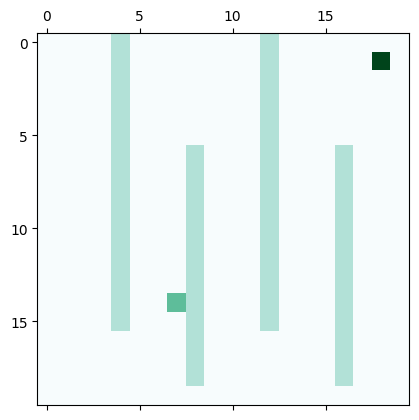

In [19]:
# plot out the maze
my_maze = hairpin(20)
maze_blank = np.zeros((20,20))

for x in my_maze[0]:
  maze_blank[x[0],x[1]] = 6
maze_blank[my_maze[1][0],my_maze[1][1]] = 10
maze_blank[my_maze[2][0],my_maze[2][1]] = 19

plt.matshow(maze_blank,cmap='BuGn')

In [20]:
def u_maze(grid_size: int):
    reward = [grid_size - 2, 1]
    blocks = []
    extra_depth = 4
    for i in range(grid_size):
        for j in range(grid_size):
            if extra_depth < j < grid_size - 1 - extra_depth and i > extra_depth:
                blocks.append([i, j])
    # find all valid start positions
    valid_starts = []
    for i in range(grid_size):
        for j in range(grid_size):
            # check if position is not in blocks and is at least 10 tiles away from goal
            if [i, j] not in blocks and abs(i - (grid_size - 2)) + abs(j - 1) >= 10:
                valid_starts.append([i, j])
    # choose random start position from valid positions
    agent_start = random.choice(valid_starts)
    #print(f'The blocks are {blocks}')
    #print(f'The agent starts at {agent_start}')
    #print(f'The reward position is at {reward}')
    return blocks, agent_start, reward

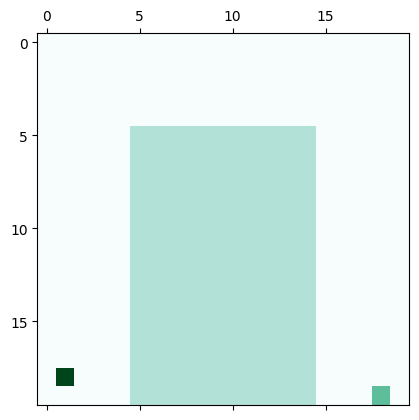

In [21]:
# plot out the maze
my_maze = u_maze(20)
maze_blank = np.zeros((20,20))

for x in my_maze[0]:
  maze_blank[x[0],x[1]] = 6
maze_blank[my_maze[1][0],my_maze[1][1]] = 10
maze_blank[my_maze[2][0],my_maze[2][1]] = 19

plt.matshow(maze_blank,cmap='BuGn')

In [ ]:
class QLearningAgent_hair:
    """
    Q-Learning Agent using softmax exploration
    """

    def __init__(
        self,
        env,
        state_size: int,
        lr: float,
        beta: float,
        action_size: int = 4,
        gamma: float = 0.99,
    ):
        self.reward = env[2]
        self.blocks = env[0]
        self.state_size = state_size
        self.action_size = action_size
        self.lr = lr
        self.gamma = gamma
        self.beta = beta
        self.Q = np.zeros((state_size, action_size))
        self.M = np.zeros((int(state_size ** 0.5), int(state_size ** 0.5)))

    def choose_action(self, state_idx):
      probs = softmax(self.Q[state_idx, :]*self.beta)
      action = np.random.choice(range(len(probs)), p=probs)
      return action

    def update_Q(self, state_idx, action, reward, next_state_idx, done):
        if done:
            target = reward
        else:
            target = reward + self.gamma * np.max(self.Q[next_state_idx, :])
        error = target - self.Q[state_idx, action]
        self.Q[state_idx, action] += self.lr * error

    def step(self, state, action, goal):        
        step_reward = 0
        next_pos = [0, 0]
        if action == 0: #moving up
            next_pos = [state[0] - 1, state[1]]
        elif action == 1: #moving down
            next_pos = [state[0] + 1, state[1]]
        elif action == 2: #moving left
            next_pos = [state[0], state[1] - 1]
        elif action == 3: #moving right
            next_pos = [state[0], state[1] + 1]
            
        if next_pos[0] <= 0 or next_pos[1] <= 0 or next_pos[0] >= int(self.state_size ** 0.5) or next_pos[1] >= int(self.state_size ** 0.5):
            next_state = state
            step_reward = 0
        elif next_pos in self.blocks:
            next_state = state
            step_reward = -0.1
        elif next_pos == self.reward:
            next_state = next_pos
            step_reward = goal
        else:
            next_state = next_pos
            step_reward = 0
        
        next_state_idx = np.ravel_multi_index(next_state, (int(self.state_size ** 0.5), int(self.state_size ** 0.5)))
        return next_state_idx, step_reward, next_state == self.reward

    def reset_env(self):
      _, state, _ = hairpin(grid_size)
      self.M = np.zeros((int(state_size ** 0.5), int(state_size ** 0.5)))
      return state

    def train(self, state, max_steps, goal): 
        total_reward = 0
        step = 0
        suc = 0
        state_idx_list = []
        action_list = []
        reward_list = []
        for step in range(max_steps):
            state_idx = np.ravel_multi_index(state, (int(self.state_size ** 0.5), int(self.state_size ** 0.5)))
            state_idx_list.append(state_idx)
            action = self.choose_action(state_idx)
            action_list.append(action)
            next_state_idx, reward, done = self.step(state, action, goal)
            reward_list.append(reward)
            self.update_Q(state_idx, action, reward, next_state_idx, done)
            state = np.unravel_index(next_state_idx, (int(self.state_size ** 0.5), int(self.state_size ** 0.5)))
            state = [state[0],state[1]]
            self.M[state[0],state[1]] += 1
            total_reward += reward
            step += 1
            if done:
                suc = 1
                break
        return total_reward, step, self.M, suc, state_idx_list, action_list, reward_list
        
    def replay(self, suc, step, state_idx_list, action_list, reward_list, success):
        my_list = list(range(0, step))
        if suc == success:
          for x in my_list[::-1]:
            # current step
            state_idx = state_idx_list[x-1]
            action = action_list[x-1]
            reward = reward_list[x-1]
            # next step
            next_action = action_list[x]
            next_state_idx = state_idx_list[x]
            # update Q values
            target = reward + self.gamma * self.Q[next_state_idx, next_action]
            error = target - self.Q[state_idx, action]
            self.Q[state_idx, action] += self.lr * error
            if x == 1:
              break

In [ ]:
class QLearningAgent_u:
    """
    Q-Learning Agent using softmax exploration
    """

    def __init__(
        self,
        env,
        state_size: int,
        lr: float,
        beta: float,
        action_size: int = 4,
        gamma: float = 0.99,
    ):
        self.reward = env[2]
        self.blocks = env[0]
        self.state_size = state_size
        self.action_size = action_size
        self.lr = lr
        self.gamma = gamma
        self.beta = beta
        self.Q = np.zeros((state_size, action_size))
        self.M = np.zeros((int(state_size ** 0.5), int(state_size ** 0.5)))

    def choose_action(self, state_idx):
      probs = softmax(self.Q[state_idx, :]*self.beta)
      action = np.random.choice(range(len(probs)), p=probs)
      return action

    def update_Q(self, state_idx, action, reward, next_state_idx, done):
        if done:
            target = reward
        else:
            target = reward + self.gamma * np.max(self.Q[next_state_idx, :])
        error = target - self.Q[state_idx, action]
        self.Q[state_idx, action] += self.lr * error

    def step(self, state, action, goal):        
        step_reward = 0
        next_pos = [0, 0]
        if action == 0: #moving up
            next_pos = [state[0] - 1, state[1]]
        elif action == 1: #moving down
            next_pos = [state[0] + 1, state[1]]
        elif action == 2: #moving left
            next_pos = [state[0], state[1] - 1]
        elif action == 3: #moving right
            next_pos = [state[0], state[1] + 1]
            
        if next_pos[0] <= 0 or next_pos[1] <= 0 or next_pos[0] >= int(self.state_size ** 0.5) or next_pos[1] >= int(self.state_size ** 0.5):
            next_state = state
            step_reward = 0
        elif next_pos in self.blocks:
            next_state = state
            step_reward = -0.1
        elif next_pos == self.reward:
            next_state = next_pos
            step_reward = goal
        else:
            next_state = next_pos
            step_reward = 0
        
        next_state_idx = np.ravel_multi_index(next_state, (int(self.state_size ** 0.5), int(self.state_size ** 0.5)))
        return next_state_idx, step_reward, next_state == self.reward

    def reset_env(self):
      _, state, _ = u_maze(grid_size)
      self.M = np.zeros((int(state_size ** 0.5), int(state_size ** 0.5)))
      return state

    def train(self, state, max_steps, goal): 
        total_reward = 0
        step = 0
        suc = 0
        state_idx_list = []
        action_list = []
        reward_list = []
        for step in range(max_steps):
            state_idx = np.ravel_multi_index(state, (int(self.state_size ** 0.5), int(self.state_size ** 0.5)))
            state_idx_list.append(state_idx)
            action = self.choose_action(state_idx)
            action_list.append(action)
            next_state_idx, reward, done = self.step(state, action, goal)
            reward_list.append(reward)
            self.update_Q(state_idx, action, reward, next_state_idx, done)
            state = np.unravel_index(next_state_idx, (int(self.state_size ** 0.5), int(self.state_size ** 0.5)))
            state = [state[0],state[1]]
            self.M[state[0],state[1]] += 1
            total_reward += reward
            step += 1
            if done:
                suc = 1
                break
        return total_reward, step, self.M, suc, state_idx_list, action_list, reward_list
        
    def replay(self, suc, step, state_idx_list, action_list, reward_list, success):
        my_list = list(range(0, step))
        if suc == success:
          for x in my_list[::-1]:
            # current step
            state_idx = state_idx_list[x-1]
            action = action_list[x-1]
            reward = reward_list[x-1]
            # next step
            next_action = action_list[x]
            next_state_idx = state_idx_list[x]
            # update Q values
            target = reward + self.gamma * self.Q[next_state_idx, next_action]
            error = target - self.Q[state_idx, action]
            self.Q[state_idx, action] += self.lr * error
            if x == 1:
              break

two-way ANOVA for maze * replay on rewards:                          sum_sq      df           F        PR(>F)
C(maze)             6169.581607     1.0  108.067930  1.735815e-24
C(replay)           2742.890920     2.0   24.022581  5.387259e-11
C(maze):C(replay)    165.156973     2.0    1.446465  2.357303e-01
Residual           85292.231640  1494.0         NaN           NaN
two-way ANOVA for maze * replay on steps:                          sum_sq      df          F        PR(>F)
C(maze)            1.200260e+06     1.0   6.578394  1.041934e-02
C(replay)          1.032971e+07     2.0  28.307576  8.578092e-13
C(maze):C(replay)  1.435918e+06     2.0   3.934996  1.974870e-02
Residual           2.725875e+08  1494.0        NaN           NaN
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Easy (U Maze)_Replay from Failure v.s. Easy (U Maze)_No Replay: t-test independent samples with

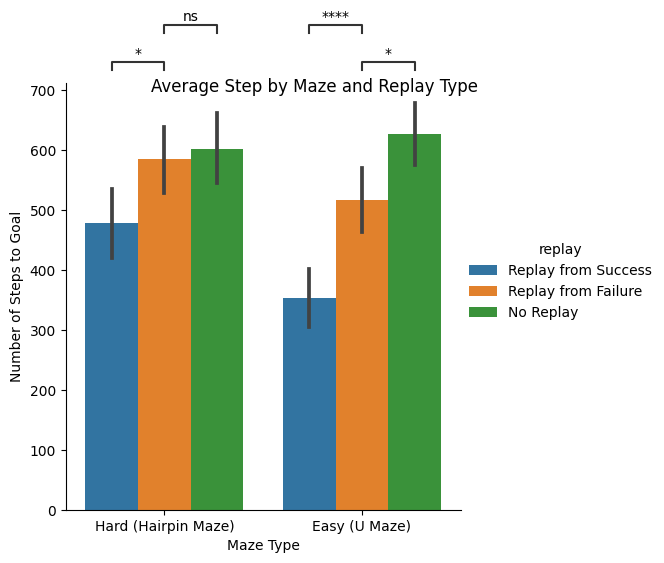

In [ ]:
np.random.seed(28649)

# Set agent parameters
grid_size = 20
env_hair = hairpin(grid_size)
env_u = u_maze(grid_size)
state_size = grid_size ** 2
lr = 0.3
beta = 1 
goal = 10
n_episodes = 250
max_steps = 1000

# Create Q-learning agent with hairpin maze - suc
agent_hair = QLearningAgent_hair(env_hair, state_size, lr, beta)
# Create Q-learning agent with U maze - suc
agent_u = QLearningAgent_u(env_u, state_size, lr, beta)

# Create Q-learning agent with hairpin maze - fail
agent_hair_fail = QLearningAgent_hair(env_hair, state_size, lr, beta)
# Create Q-learning agent with U maze - fail
agent_u_fail = QLearningAgent_u(env_u, state_size, lr, beta)

# Create Q-learning agent with hairpin maze - no replay
agent_hair_no = QLearningAgent_hair(env_hair, state_size, lr, beta)
# Create Q-learning agent with U maze - no replay
agent_u_no = QLearningAgent_u(env_u, state_size, lr, beta)

# Initialize lists to store data
data = {"maze": [], "replay": [], "steps": [], "rewards": []}

# Train and compare the agent in the two mazes for each test condition
for episode in range(n_episodes):
    # Train with hairpin maze - suc
    state_hair = agent_hair.reset_env()
    rews, step, M, suc, state_idx_list, action_list, reward_list = agent_hair.train(state_hair, max_steps, goal)
    agent_hair.replay(suc, step, state_idx_list, action_list, reward_list, 1)
    data["maze"].append(int(1))
    data["replay"].append(int(1))
    data["steps"].append(step)
    data["rewards"].append(rews)

    # Train with u maze - suc
    state_u = agent_u.reset_env()
    rews, step, M, suc, state_idx_list, action_list, reward_list = agent_u.train(state_u, max_steps, goal)
    agent_u.replay(suc, step, state_idx_list, action_list, reward_list, 1)
    data["maze"].append(int(0))
    data["replay"].append(int(1))
    data["steps"].append(step)
    data["rewards"].append(rews)

    # Train with hairpin maze - fail
    state_hair = agent_hair_fail.reset_env()
    rews, step, M, suc, state_idx_list, action_list, reward_list = agent_hair_fail.train(state_hair, max_steps, goal)
    agent_hair_fail.replay(suc, step, state_idx_list, action_list, reward_list, 0)
    data["maze"].append(int(1))
    data["replay"].append(int(2))
    data["steps"].append(step)
    data["rewards"].append(rews)

    # Train with u maze - fail
    state_u = agent_u_fail.reset_env()
    rews, step, M, suc, state_idx_list, action_list, reward_list = agent_u_fail.train(state_u, max_steps, goal)
    agent_u_fail.replay(suc, step, state_idx_list, action_list, reward_list, 0)
    data["maze"].append(int(0))
    data["replay"].append(int(2))
    data["steps"].append(step)
    data["rewards"].append(rews)

    # Train with hairpin maze -  no replay
    state_hair = agent_hair_no.reset_env()
    rews, step, M, suc, state_idx_list, action_list, reward_list = agent_hair_no.train(state_hair, max_steps, goal)
    data["maze"].append(int(1))
    data["replay"].append(int(0))
    data["steps"].append(step)
    data["rewards"].append(rews)

    # Train with u maze - no replay
    state_u = agent_u_no.reset_env()
    rews, step, M, suc, state_idx_list, action_list, reward_list = agent_u_no.train(state_u, max_steps, goal)
    data["maze"].append(int(0))
    data["replay"].append(int(0))
    data["steps"].append(step)
    data["rewards"].append(rews)


df = pd.DataFrame(data)

# Perform two-way ANOVA for maze * replay on rewards
formula = "rewards ~ C(maze) * C(replay)"
model = ols(formula, data=df).fit()
anova_results_rews = sm.stats.anova_lm(model, typ=2)
print("two-way ANOVA for maze * replay on rewards:", anova_results_rews)

# Perform two-way ANOVA for maze * replay on steps
formula = "steps ~ C(maze) * C(replay)"
model = ols(formula, data=df).fit()
anova_results_steps = sm.stats.anova_lm(model, typ=2)
print("two-way ANOVA for maze * replay on steps:", anova_results_steps)


# Rename level names
df["replay"] = df["replay"].replace({0: "No Replay", 1: "Replay from Success", 2: "Replay from Failure"})
df["maze"] = df["maze"].replace({0: "Easy (U Maze)", 1: "Hard (Hairpin Maze)"})

# Create bar plot
plot = sns.catplot(x="maze", y="steps", hue="replay", data=df, kind="bar")

# Set axis labels
plot.set(xlabel="Maze Type", ylabel="Number of Steps to Goal")

# Set title
plot.fig.suptitle("Average Step by Maze and Replay Type")

# Add significance indicators using statannot
test_results = add_stat_annotation(plot.ax, data=df, x="maze", y="steps", hue="replay",
                                   box_pairs=[(("Easy (U Maze)", "Replay from Success"), ("Easy (U Maze)", "Replay from Failure")),
                                              (("Hard (Hairpin Maze)", "Replay from Success"), ("Hard (Hairpin Maze)", "Replay from Failure")),
                                              (("Easy (U Maze)", "No Replay"), ("Easy (U Maze)", "Replay from Failure")),
                                              (("Hard (Hairpin Maze)", "No Replay"), ("Hard (Hairpin Maze)", "Replay from Failure"))],
                                   test="t-test_ind", text_format="star", loc="outside")
# Show plot
plt.show()
